# Making predictions on Protegrin-1 mutants 

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [1]:
import os
import torch
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted, venn2_unweighted
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
# Load the pickled model trained only on protegrin variants 

# model trained on MBC data
model_GNB_mbc = joblib.load('models/model_v01.2_GNB_esm2_15B_activity_classification_corr03.pkl')
corr_columns_mic = pickle.load(open('models/correlated_columns_v01.2_esm2_15B_activity_corr03.pkl', 'rb'))

# model trained on hemolysis data
model_SVR_hemo = joblib.load('models/model_v01.2_Lasso_esm2_15B_Hemolysis_regression_corr06.pkl')
corr_columns_hemo = pickle.load(open('models/correlated_columns_v01.2_esm2_15B_hemolysis_corr06.pkl', 'rb'))

# model to predict selectivity
model_SVR_sel = joblib.load('models/model_v01.2_SVR_esm2_15B_selectivity_regression_corr065.pkl')
corr_columns_sel = pickle.load(open('models/correlated_columns_v01.2_esm2_15B_selectivity_corr065.pkl', 'rb'))

## Predictions on single mutation Protegrin-1 Variants

In [3]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_1mut.csv', index_col=0)
meta_data

,ID,Sequence
0,1mut_0,RGGRLCYCRRRFCVLVGR
1,1mut_1,RMGRLCYCRRRFCVCVGR
2,1mut_2,RGGRLCYCRRRFCVCVFR
3,1mut_3,EGGRLCYCRRRFCVCVGR
4,1mut_4,RGGNLCYCRRRFCVCVGR
...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR
339,1mut_339,RGGRLCYCRRKFCVCVGR
340,1mut_340,RGGRLCHCRRRFCVCVGR
341,1mut_341,RGGRLCYCRRDFCVCVGR


In [4]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = 'data/embedding/esm2_15B_pg1_1mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
#df

In [5]:
# load embeddings from a pickle file
df = pd.read_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,1mut_0,RGGRLCYCRRRFCVLVGR,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,1mut_1,RMGRLCYCRRRFCVCVGR,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,1mut_3,EGGRLCYCRRRFCVCVGR,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077

## Predicting active variants with AMP MBC <= 8

In [6]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,-0.175508,0.016926,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,-0.090511,0.077786,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,-0.093007,-0.003598,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,-0.118641,0.097144,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077252,-0.082461,0.261394,0.016504,0

In [7]:
features1 = features[corr_columns_mic]
features1.head()

,3631,4026,4066,1826,36,1767,2064,946,1461,971,3920,2103,3417,2234,303,1773,1576,3447,2265,4011,4962,4351,4892,3418,2930,2111,2231,1995,2124,4919,1761,3286,3041,3313,3750,1864,274,475,964,2107,3235,3645,3332,657,3140,4553,1020,4694,837,3563,...,620,1142,1271,156,4401,985,5017,1794,2020,4661,3886,550,5074,3182,14,1190,4061,4971,4602,5078,2114,568,3863,285,1724,4664,1658,3877,2505,5088,4194,248,4621,454,1739,591,2138,2856,2184,4501,4798,487,471,4208,5097,5040,2513,161,3928,298
0,0.295925,-0.242120,0.167013,0.063869,0.182056,-0.081493,0.073252,-0.021091,0.000907,-0.126511,-0.198422,0.157931,-0.035073,-0.185176,0.217157,0.281587,0.038734,0.177745,0.144090,-0.138290,-0.129770,-0.270526,-0.088028,0.210553,0.105362,-0.111635,-0.059913,-0.027770,-0.095960,0.056549,0.042887,0.269902,-0.017413,-0.003312,-0.096829,-0.076103,-0.003425,-0.039563,0.070706,-0.000164,-0.137018,-0.114083,-0.033518,0.102217,-0.006107,-0.072734,0.089712,-0.014140,0.013101,0.165262,...,-0.030247,0.140166,0.294648,-0.273808,0.108743,-0.052881,0.136800,-0.009918,0.147446,-0.101078,0.009228,0.008433,-0.145865,0.134994,0.172095,-0.166064,0.024571,0.156423,0.081344,0.266587,-0.068114,-0.481086,0.016473,-0.027372,0.112814,-0.057424,0.098685,0.200954,-0.160305,-0.113380,-0.173411,0.260358,0.152904,-0.012075,-0.139789,0.010012,-0.096958,0.104122,0.172950,0.247138,0.102225,0.188541,0.027510,-0.098444,0.001308,-0.000299,-0.048910,0.056056,-0.109122,0.081819
1,0.250831,-0.210576,0.060968,-0.009510,0.186130,-0.105435,-0.021967,-0.013764,0.080433,-0.034848,-0.154932,0.124403,0.043585,-0.171345,0.167718,0.126912,0.022994,0.158764,0.082624,-0.189613,-0.049135,-0.139440,-0.136599,0.228204,0.105021,-0.071652,-0.126368,0.006084,-0.115036,0.134146,0.047768,0.257552,-0.086875,0.024079,-0.065470,-0.091035,-0.041541,0.004994,0.155991,0.097429,-0.084823,-0.060201,-0.002158,-0.031266,-0.193706,-0.022264,0.084303,-0.013811,0.057100,0.223617,...,0.020615,0.069761,0.250253,-0.236020,0.120356,-0.123138,0.066734,0.050427,0.079264,-0.059357,0.042818,-0.035389,-0.048187,0.101306,0.076887,-0.100897,0.023816,0.140845,0.036889,0.180409,-0.087783,-0.378558,-0.012693,-0.000289,0.179430,-0.123188,0.020760,0.165790,-0.167110,-0.088200,-0.143638,0.139897,0.119676,-0.002877,-0.075977,0.027919,-0.073405,0.051188,0.133208,0.186449,0.059309,0.155844,0.074690,-0.063735,-0.002016,0.037642,-0.017852,0.024680,-0.076351,0.055377
2,0.189448,-0.198901,0.126283,-0.032547,0.152275,-0.101898,-0.050272,0.027468,0.088600,-0.056368,-0.154721,0.107647,0.055131,-0.206999,0.115218,0.123672,0.046325,0.120904,0.081414,-0.239348,-0.047712,-0.170929,-0.078417,0.176191,0.084944,-0.073507,-0.110983,-0.007991,-0.136806,0.125949,0.090306,0.315210,-0.109947,0.050130,-0.060447,-0.055377,0.028978,-0.050322,0.125004,-0.004303,-0.127592,-0.061179,0.015894,0.006144,-0.169938,-0.052995,0.123099,0.023100,0.033719,0.220058,...,0.100700,0.095771,0.226416,-0.194992,0.113335,-0.016810,0.048021,0.058570,0.042933,-0.075682,0.023360,0.020446,-0.031800,0.156271,0.000999,-0.027998,0.056344,0.168250,-0.002072,0.183440,-0.069149,-0.321463,-0.083802,0.035832,0.208959,-0.142064,0.020557,0.168984,-0.176259,-0.108814,-0.076506,0.181103,0.107856,-0.013030,-0.087866,0.027987,-0.108985,0.013377,0.136345,0.154380,0.038610,0.134776,0.122032,-0.136953,-0.033838,0.044689,-0.004334,-0.041895,-0.088479,0.012718
3,0.276478,-0.187747,0.119757,-0.004543,0.196983,-0.080688,0.025091,0.028455,0.033829,-0.053059,-0.146947,0.130832,0.003023,-0.180767,0.143554,0.163057,0.021029,0.144590,0.072318,-0.183481,-0.100414,-0.204029,-0.104086,0.204415,0.118218,-0.075167,-0.131791,0.003893,-0.061813,0.067725,0.057835,0.288460,-0.086537,0.033689,-0.086501,-0.060304,-0.063066,0.007112,0.130788,0.066832,-0.086608,-0.108636,0.019519,0.006068,-0.147062,-0.059386,0.088136,-0.001418,0.048026,0.225348,...,0.042089,0.124159,0.235368,-0.203245,0.158414,-0.086953,0.067648,0.029067,0.110109,-0.102808,0.036870,-0.029042,-0.123913,0.126110,0.115235,-0.078098,0.043701,0.161957,-0.006261,0.247

In [8]:
# creates a df to save probabilities
res_GNB = df.iloc[:,0:1].copy()

# calculates the probability of being active
prob= model_GNB_mbc.predict_proba(features1)
prob= [(x[1]*100).round(2) for x in prob]

res_GNB['MBC_8_prob']=prob

#number of peptides with probability == 100%
print(f"{res_GNB.query('MBC_8_prob == 100').shape[0]} peptides with probability == 100% to be active")

222 peptides with probability == 100% to be active


### Predicting selectivity score

In [9]:
features2 = features[corr_columns_sel]
features2.head()

,2156,2623,3006,2530,3896,4531,502,3033,4603,1964,4090,2251,3284,1935,2761,4514,2951,2983,472,4801,4027,620,3448,2985,122,3205,4467,2917,4617,2742,1757,2963,1537,1484,4118,85,1571,1645,1012,1658,365,487,2045,5016,4667,1194,4320,254,3182,1090,2290,332,646,3668,2307,4691,3427,5040,507,4385,4664,1603,2231,197,1994,2210,3863,2560,1739,4885,2990,3775,312,4468,4707,1876,3895,609,4672
0,0.316914,0.133888,0.165485,0.219287,0.005795,0.138278,0.190562,0.100969,-0.198953,0.030877,-0.295455,-0.130345,0.001749,-0.071333,-0.073157,-0.325801,-0.005251,-0.134178,-0.177722,-0.121746,0.083719,-0.030247,0.095069,0.204233,-0.129875,-0.098153,-0.009536,0.157045,0.115093,0.012345,0.143856,0.103582,-0.083215,-0.187637,-0.060929,-0.192945,0.011973,0.064210,0.044195,0.098685,-0.133377,0.188541,0.095624,-0.180989,0.152122,0.082203,-0.213870,-0.127766,0.134994,0.008414,0.079548,-0.127265,0.272669,0.279339,-0.171858,-0.055522,0.040830,-0.000299,-0.048106,0.000320,-0.057424,-0.258994,-0.059913,-0.022343,0.227568,-0.116951,0.016473,-0.235236,-0.139789,0.083098,0.211681,0.103510,-0.098713,-0.336973,0.083653,0.321159,0.128183,-0.057011,-0.043930
1,0.247514,0.110006,0.025019,0.167552,0.040785,0.013030,0.083217,-0.013882,-0.028441,-0.039021,-0.169919,-0.041991,0.055421,-0.021226,-0.074402,-0.277303,0.068798,-0.137941,-0.106809,-0.091816,0.028207,0.020615,0.021804,0.136305,-0.017604,-0.041836,-0.001940,0.238943,0.034722,-0.011705,-0.028060,0.041976,-0.025361,-0.183244,-0.145703,-0.090543,0.075615,0.022303,0.105810,0.020760,-0.050371,0.155844,0.011238,-0.191518,0.241090,0.093544,-0.131049,-0.180463,0.101306,-0.066947,0.078916,-0.078862,0.195092,0.153149,-0.075150,-0.108124,-0.075250,0.037642,-0.056348,0.016244,-0.123188,-0.194733,-0.126368,-0.169353,0.317833,-0.010017,-0.012693,-0.233748,-0.075977,-0.003912,0.118771,0.145114,-0.020273,-0.216888,0.032632,0.214837,0.019695,-0.035800,0.033320
2,0.200300,0.049459,0.065939,0.167296,0.037434,0.031106,0.108506,0.014452,-0.083313,-0.094369,-0.175193,-0.051597,0.059414,0.030091,-0.023948,-0.243607,0.068406,-0.166962,-0.137208,-0.114895,0.012523,0.100700,0.026789,0.135875,-0.010096,-0.008321,0.056658,0.214022,0.033992,-0.090221,-0.019194,0.076375,-0.099021,-0.234931,-0.153534,-0.117524,0.075873,0.043760,0.102304,0.020557,-0.020794,0.134776,0.036274,-0.153236,0.219400,0.046362,-0.130498,-0.262258,0.156271,-0.091339,0.047683,-0.085990,0.226329,0.174312,-0.101392,-0.073100,-0.103785,0.044689,-0.072596,0.082250,-0.142064,-0.233575,-0.110983,-0.186726,0.329537,-0.027105,-0.083802,-0.224664,-0.087866,0.002511,0.061816,0.220941,-0.020943,-0.225501,0.033557,0.271957,-0.001894,0.057719,0.059173
3,0.262885,0.122060,0.049670,0.220331,0.021971,0.016429,0.134832,-0.021566,-0.087972,-0.039192,-0.241906,-0.040926,0.107756,-0.040865,-0.069702,-0.277580,0.035794,-0.103118,-0.140858,-0.133212,0.028996,0.042089,0.031861,0.159370,-0.059679,-0.034349,0.026619,0.204531,0.047528,0.036264,-0.017368,0.082461,-0.022948,-0.183201,-0.167473,-0.070006,0.026955,0.036872,0.083279,0.073986,-0.053381,0.153913,0.058955,-0.200015,0.215191,0.074695,-0.121165,-0.183919,0.126110,0.000376,0.051635,-0.105172,0.260710,0.160587,-0.144557,-0.126532,-0.094587,0.028460,-0.060010,0.009505,-0.079216,-0.214275,-0.131791,-0.144703,0.319411,-0.022645,-0.025485,-0.221291,-0.116467,0.011188,0.161175,0.108426,-0.033655,-0.212589,0.030716,0.221345,0.084448,0.005288,0.026848
4,0.230725,0.067553,0.058238,0.239368,0.034779,0.015927,0.111428,0.020500,-0.094747,-0.038990,-0.229986,-0.080027,0.106712,-0.041797,-0.058070,-0.284382,0.047071,-0.101410,-0.131763,-0.103706,0.047438,0.034306,0.036145,0.157087,-0.062504,0.003385,0.050751,0.178180,0.068373,0.010175,-0.006472,0.043826,-0.075219,-0.170017,-0.155436,-0.076816,0.051769,0.047510,0.083834,0.074304,-0.014229,0.157561,0.078213,-0.175569,0.219197,0.091785,-0.161756,-0.192189,0.115586,-0.049176,0.053376,-0.097292,0.225143,0.215206,-0.142996,-0.103003,-0.064907,0.052607,-0.044552,0.020002,-0.093421,-0.187675,-0.123679,-0.144751,0.30

In [10]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
prob= model_SVR_sel.predict(features2)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.5
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction of Hemolysis % to protegrin-1 variants

In [11]:
features3 = features[corr_columns_hemo]
features3.head()

,4358,1901,4619,1777,2856,4623,3128,4145,4299,4484,4435,3520,1584,3285,1739,472,3404,1944,2714,3896,3482,4304,2964,48,4936,1971,4514,1518,3316,2655,3788,3006,2267,838,2923,3775,3712,2789,312,1155,2397,2917,3284,4617,4642,2233,3586,1370,4030,1417,...,2826,1916,3701,2492,3457,1571,912,4032,2990,2939,3466,3033,4385,2607,2067,809,3448,4027,3473,4926,2045,2093,1487,2772,783,2284,3942,4402,4686,2951,3399,4948,4040,1336,3891,4603,3718,933,2210,365,935,3427,646,1586,197,1757,609,4885,4468,1012
0,0.217128,-0.186775,-0.207822,-0.890151,0.104122,0.145655,0.249626,-0.152060,-0.049228,0.186836,-0.038690,-0.008260,0.041406,0.066750,-0.139789,-0.177722,-0.279815,-0.089450,-0.051162,0.005795,-0.093823,-0.209805,0.058046,-0.175508,0.076435,0.040915,-0.325801,0.028973,-0.210691,-0.387280,0.083730,0.165485,-0.204953,0.038528,0.044122,0.103510,0.117223,0.164936,-0.098713,-0.270531,-0.152582,0.157045,0.001749,0.115093,-0.043062,0.043278,0.003744,-0.098315,-0.153271,-0.289544,...,-0.167059,-0.091951,-0.074190,0.076805,-0.109499,0.011973,-0.079815,0.178448,0.211681,-0.063050,-0.016370,0.100969,0.000320,-0.430121,-0.083275,0.170391,0.095069,0.083719,-0.070069,-0.089523,0.095624,-0.068355,0.100181,-0.015495,-0.057562,0.032309,-0.078187,-0.046740,0.048576,-0.005251,0.000218,-0.120265,-0.099890,0.089451,0.154824,-0.198953,-0.090117,-0.045577,-0.116951,-0.133377,-0.051211,0.040830,0.272669,0.184653,-0.022343,0.143856,-0.057011,0.083098,-0.336973,0.044195
1,0.107648,-0.124903,-0.154989,-0.663329,0.051188,0.224679,0.157115,-0.213559,-0.181494,0.032451,-0.010583,-0.113410,0.124761,-0.005504,-0.075977,-0.106809,-0.184245,-0.049736,0.120021,0.040785,0.050217,-0.265365,0.073642,-0.090511,-0.028179,-0.001556,-0.277303,-0.036342,-0.012253,-0.276300,-0.036408,0.025019,-0.297348,0.144452,-0.055525,0.145114,0.043523,0.274255,-0.020273,-0.174019,-0.027996,0.238943,0.055421,0.034722,0.050471,0.179608,0.062844,-0.041966,-0.066140,-0.269395,...,-0.073628,0.011395,-0.202569,-0.095291,-0.183615,0.075615,-0.167485,0.042790,0.118771,0.155203,-0.110939,-0.013882,0.016244,-0.371703,0.013657,0.109096,0.021804,0.028207,0.004879,0.022190,0.011238,0.085485,-0.018277,-0.103544,0.056716,0.071136,-0.076833,-0.160793,0.172737,0.068798,0.126776,0.036691,-0.035327,0.143387,0.252215,-0.028441,-0.064453,-0.111541,-0.010017,-0.050371,-0.128424,-0.075250,0.195092,0.243829,-0.169353,-0.028060,-0.035800,-0.003912,-0.216888,0.105810
2,0.096685,-0.117793,-0.160030,-0.688115,0.013377,0.185849,0.203057,-0.243054,-0.131509,0.091401,-0.026314,-0.052209,0.131111,-0.006600,-0.087866,-0.137208,-0.232953,-0.010652,0.078191,0.037434,0.045446,-0.286628,0.053022,-0.093007,0.004643,-0.009288,-0.243607,-0.031015,0.006433,-0.268628,-0.045081,0.065939,-0.311183,0.136877,-0.073788,0.220941,0.021477,0.261384,-0.020943,-0.170651,-0.054040,0.214022,0.059414,0.033992,0.039593,0.108461,0.056378,-0.056969,-0.057147,-0.230433,...,-0.071105,-0.003303,-0.184348,-0.103320,-0.203652,0.075873,-0.171245,0.059183,0.061816,0.183560,-0.105249,0.014452,0.082250,-0.340766,0.005703,0.092241,0.026789,0.012523,-0.005141,-0.052626,0.036274,0.137320,0.008819,-0.153893,0.080561,0.079028,-0.059329,-0.200058,0.158811,0.068406,0.134488,0.066705,-0.034635,0.116200,0.271434,-0.083313,-0.035127,-0.120600,-0.027105,-0.020794,-0.122072,-0.103785,0.226329,0.246068,-0.186726,-0.019194,0.057719,0.002511,-0.225501,0.102304
3,0.113175,-0.154276,-0.132477,-0.652215,0.072112,0.203771,0.208632,-0.232611,-0.141950,0.077290,-0.018136,-0.109010,0.105711,0.005725,-0.116467,-0.140858,-0.201781,-0.027220,0.060352,0.021971,0.056460,-0.285506,0.067296,-0.118641,0.025931,0.046731,-0.277580,0.002781,-0.022896,-0.318044,-0.032710,0.049670,-0.268506,0.115405,-0.018237,0.108426,0.078003,0.235092,-0.033655,-0.204743,-0.084482,0.204531,0.107756,0.047528,0.041737,0.084542,0.066851,-0.102109,-0.059750,-0.312874,...,-0.073863,0.060228,-0.132326,-0.002207,-0.185606,0.026955,-0.127501,0.078568,0.161175,0.112114,-0.117374,-0.021566,0.009505,-0.388407,0.008589,0.122895

In [12]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
pred= model_SVR_hemo.predict(features3)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

9 peptides with predicted hemolysis% < 2%


## Results of single mutant

In [13]:
results = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,100.0,1.94,8.910000
1,1mut_1,RMGRLCYCRRRFCVCVGR,100.0,2.34,35.299999
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.0,2.81,42.709999
3,1mut_3,EGGRLCYCRRRFCVCVGR,100.0,2.30,30.990000
4,1mut_4,RGGNLCYCRRRFCVCVGR,100.0,2.23,28.780001
...,...,...,...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR,100.0,2.72,15.270000
339,1mut_339,RGGRLCYCRRKFCVCVGR,100.0,2.32,28.280001
340,1mut_340,RGGRLCHCRRRFCVCVGR,100.0,1.86,14.550000
341,1mut_341,RGGRLCYCRRDFCVCVGR,100.0,2.17,17.010000


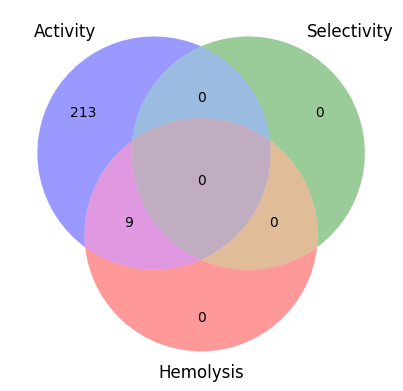

In [14]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MBC_HEMO_SEL_2mut_venn3_predictions_v03.png')
plt.show()

In [15]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1mut_v01.2.csv')

## Predictions on double mutation Protegrin-1 Variants

In [16]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_2mut.csv', index_col=0)
meta_data

,ID,Sequence
0,2mut_0,RGPRLCYCRRRQCVCVGR
1,2mut_1,YGGPLCYCRRRFCVCVGR
2,2mut_2,RKGRLCGCRRRFCVCVGR
3,2mut_3,RGGRLCYCRRWFCVKVGR
4,2mut_4,RGGRLCYCMRRFCVCDGR
...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR
55572,2mut_55572,RGGRLCYCRRRHDVCVGR
55573,2mut_55573,RGGRMCYCRRRFCVCVAR
55574,2mut_55574,RGGRLCYCRIRFIVCVGR


In [17]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = '/stor/work/Wilke/luiz/ML_PG1/embeddings/esm2_15B_pg1_2mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_2mut.pkl')

In [18]:
# load embeddings from a pickle file
df = pd.read_pickle(f'data/embedding/esm2_15B_pg1_2mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,2mut_0,RGPRLCYCRRRQCVCVGR,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,2mut_1,YGGPLCYCRRRFCVCVGR,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,2mut_2,RKGRLCGCRRRFCVCVGR,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.0

### Prediction of active variants (MBC <= 8)

In [19]:
# creates a df to save predictions
features = df.iloc[:,2:]
features1 = features[corr_columns_mic]

# creates a df to save probabilities
res_GNB = df.iloc[:,0:1].copy()

# calculates the probability of being active
prob= model_GNB_mbc.predict_proba(features1)
prob= [(x[1]*100).round(2) for x in prob]

res_GNB['MBC_8_prob']=prob

#number of peptides with probability == 100%
print(f"{res_GNB.query('MBC_8_prob == 100').shape[0]} peptides with probability == 100% to be active")

36458 peptides with probability == 100% to be active


### Predicting selectivity score

In [20]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
prob= model_SVR_sel.predict(features[corr_columns_sel])
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.5
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

301 peptides with selectivity score < 0.5


### Prediction nom Hemolitic variants (hemolysis% < 2%)

In [21]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
pred= model_SVR_hemo.predict(features[corr_columns_hemo])
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis < 2%
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

4792 peptides with predicted hemolysis% < 2%


### Results of double mutants

In [22]:
results = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,2mut_0,RGPRLCYCRRRQCVCVGR,99.17,1.64,14.900000
1,2mut_1,YGGPLCYCRRRFCVCVGR,100.00,2.38,30.129999
2,2mut_2,RKGRLCGCRRRFCVCVGR,100.00,2.21,6.730000
3,2mut_3,RGGRLCYCRRWFCVKVGR,98.46,2.42,17.590000
4,2mut_4,RGGRLCYCMRRFCVCDGR,100.00,1.95,23.129999
...,...,...,...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR,0.00,2.92,28.740000
55572,2mut_55572,RGGRLCYCRRRHDVCVGR,0.00,0.98,-0.270000
55573,2mut_55573,RGGRMCYCRRRFCVCVAR,100.00,2.01,17.260000
55574,2mut_55574,RGGRLCYCRIRFIVCVGR,100.00,3.01,18.600000


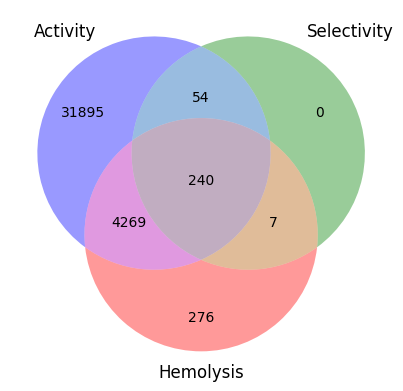

In [23]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MBC_HEMO_SEL_2mut_venn3_predictions_v03.png')
plt.show()

In [24]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_2mut_v01.2.csv')

# Predictions on triple mutant Protegrin-1 Variants

In [25]:
### Those functions will be used to predict the triple mutants in a loop
def run_GNB(features):    
    # creates a df to save probabilities
    res_GNB = pd.DataFrame()
    
    features1 = features[corr_columns_mic]

    # calculates the probability of being active
    prob= model_GNB_mbc.predict_proba(features1)
    prob= [(x[1]*100).round(2) for x in prob]
    
    res_GNB['ID']=features.index
    res_GNB['MBC_8_prob']=prob

    return res_GNB

In [26]:
### Predicting selectivity score
def run_SVR_sel(features, corr_columns):
    # creates a df to selectivity score
    res_sel = pd.DataFrame()

    # calculates the the selectivity score
    prob= model_SVR_sel.predict(features[corr_columns])

    res_sel['ID']=features.index
    res_sel['selectivity_pred']= prob.round(2) 

    return res_sel

In [27]:
### Prediction nom Hemolitic variants (hemolysis% < 2%)
def run_SVR_hemo(features, corr_columns):
    # creates a df to save hemolysis score
    res_hemo = pd.DataFrame()

    # calculates the the hemolysis score
    pred= model_SVR_hemo.predict(features[corr_columns])

    res_hemo['ID']=features.index
    res_hemo['hemolysis_pred']= pred.round(2)

    return res_hemo

### Preprocess the embedding from a tensor file to a lighter pickle file

In [28]:
# import multiprocessing

# # this was required to load the embeddings with multiple CPUs due the large file sizes
# for i in range(1,7):
#     '''this loop will load the embeddings with multiple CPUs and save them in a pickle file'''

#     # Set the directory containing the Torch files
#     data_dir = f'data/embedding/esm2_15B_pg1_3mut/esm2_15B_pg1_3mut_{i}mil/'

#     # Define the function to load a Torch file
#     def load_torch_file(filename):
#         filepath = os.path.join(data_dir, filename)
#         label = filename.split('.pt')[0]
#         embeddings = {}
#         embeddings[label] = np.array(torch.load(filepath)['mean_representations'][48])
#         return embeddings

#     # Get a list of all the Torch files in the directory
#     file_list = os.listdir(data_dir)

#     # Define the number of processes to use
#     num_processes = 50

#     # Create a multiprocessing pool with the number of processes defined above
#     pool = multiprocessing.Pool(processes=num_processes)

#     # Use the pool to load all the Torch files in parallel
#     results = pool.map(load_torch_file, file_list)

#     # Close the pool
#     pool.close()

#     # Concatenate the results into a single list
#     all_data = {k: v for d in results for k, v in d.items()}

#     # Convert the dictionary to a NumPy array
#     arr = np.array(list(all_data.values()))

#     # Set the keys as the index
#     index = list(all_data.keys())

#     # Create a DataFrame from the array
#     df = pd.DataFrame(arr, index=index)

#     # Print the DataFrame and renamed it
#     df.to_pickle(f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl')

### Loaning the pre processced embedding from a pickle file and run prediction on each splited file
I have to split the files in 6 parts due its huge size

In [29]:
# read the CSV files and concatenate them row-wise
predictions = pd.DataFrame()

for i in range(1, 7):
    file_path = f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl'
    features = pd.read_pickle(file_path)
    print(f'Processing file esm2_15B_pg1_3mut_{i}mil, size: {features.shape}')
    
    res_GNB = run_GNB(features)
    res_sel = run_SVR_sel(features, corr_columns_sel)
    res_hemo = run_SVR_hemo(features, corr_columns_hemo)
    
    res = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
    res = res.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')

    predictions = pd.concat([predictions, res], axis=0).reset_index(drop=True)
    print(f'Prediction size: {predictions.shape[0]}')

predictions

Processing file esm2_15B_pg1_3mut_1mil, size: (1000000, 5120)
Prediction size: 1000000


## Load meta data and merge with results

In [ ]:
meta_data = pd.read_csv('data/protegrin_variants_3mut.csv', index_col=0)
results = meta_data.merge(predictions, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_0,HGGRLCYCRRRFCVCQTR,100.0,0.68,17.540001
1,PG1_3mut_1,RGGQLCYVRRRFCVAVGR,100.0,1.88,-4.060000
2,PG1_3mut_2,RCYRLCRCRRRFCVCVGR,0.0,2.33,17.820000
3,PG1_3mut_3,RGSRLCYCRRRFCMCVIR,0.0,2.41,43.610001
4,PG1_3mut_4,RGGRRCYCWRAFCVCVGR,0.0,2.99,39.060001
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,100.0,2.08,18.200001
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.0,3.23,17.799999
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.0,3.41,22.990000
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,100.0,1.47,4.330000


In [ ]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_3mut_v01.2.csv')

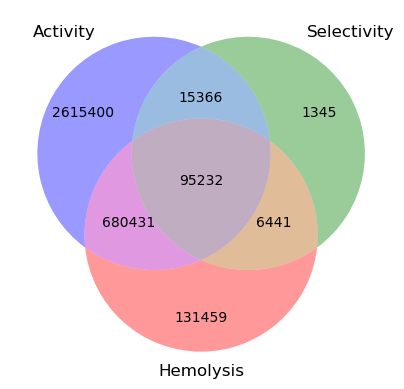

In [ ]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
plt.show()

# Merge predictions and visualization

In [ ]:
# loop trhrough the 3 predictions files and concatenate them
files = []
for i in range(1, 4):
    file = pd.read_csv(f'results/predictions_MIC_SEL_HEMO_models_PG1_{i}mut_v01.2.csv', index_col=0)
    files.append(file)

data = pd.concat(files, axis=0)
data

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,100.0,1.94,8.91
1,1mut_1,RMGRLCYCRRRFCVCVGR,100.0,2.34,35.30
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.0,2.81,42.71
3,1mut_3,EGGRLCYCRRRFCVCVGR,100.0,2.30,30.99
4,1mut_4,RGGNLCYCRRRFCVCVGR,100.0,2.23,28.78
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,100.0,2.08,18.20
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.0,3.23,17.80
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.0,3.41,22.99
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,100.0,1.47,4.33


In [ ]:
## save the file compressed
data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v01.2.csv.gz', index=False, compression='gzip')
## lOAD the file
#data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut.csv.gz', compression='gzip')

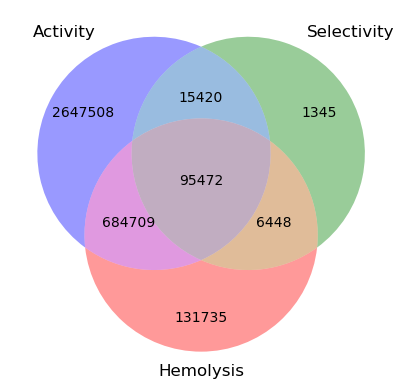

In [ ]:
#Define the sets as lists of elements
set1 = set(data.query('MBC_8_prob == 100')['ID'].values)
set2 = set(data.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(data.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('results/MBC_HEMO_SEL_all_mutations_venn3_predictions_most_active.png')

plt.show()

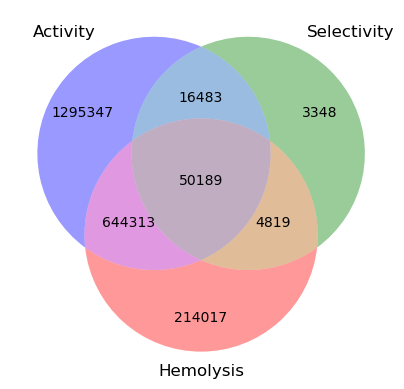

In [ ]:
#Define the sets as lists of elements
set1 = set(data.query('MBC_8_prob == 0')['ID'].values)
set2 = set(data.query('selectivity_pred > 3.5')['ID'].values)
set3 = set(data.query('hemolysis_pred > 30')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))

#plt.savefig('results/MBC_HEMO_SEL_all_mutations_venn3_predictions_least_active.png')

plt.show()

In [ ]:
### Most active
most_act = data.query('MBC_8_prob == 100 and selectivity_pred < 0.5 and hemolysis_pred <=2').copy()

### Least active
least_act = data.query('MBC_8_prob == 0 and selectivity_pred > 3.5 and hemolysis_pred > 30').copy()

low_hemo = data.query('hemolysis_pred <= 2').copy()

low_mic = data.query('MBC_8_prob == 100').copy()


print(f"Number of peptides: {most_act.shape[0]}")
print(f"Number of peptides: {least_act.shape[0]}")
print(f"Number of peptides: {low_hemo.shape[0]}")
print(f"Number of peptides: {low_mic.shape[0]}")

Number of peptides: 95472
Number of peptides: 50189
Number of peptides: 918364
Number of peptides: 3443109


In [ ]:
stop

### AA frequency change in most active peptides

In [ ]:
# def to find the differences between the residues
idx = "RRRRICYCPLRFYVCVGR"

def diff_func(idxx):
    pg1 = "RGGRLCYCRRRFCVCVGR"
    idx = idxx
    diff = []
    for i in range(0, len(pg1)):
        aa = idx[i]
        pg_aa = pg1[i]
        
        if pg_aa == aa:
            diff.append("-")
        else:
            diff.append(aa)
    diff_seq = "".join(diff)
    return diff_seq


diff_func(idx)

'-RR-I---PL--Y-----'

In [ ]:
most_act["difference_in_seq"] = [diff_func(x) for x in most_act["Sequence"]]
most_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq
282,2mut_282,RGGRLCYDRRRFCVTVGR,100.0,0.18,-12.96,-------D------T---
473,2mut_473,RGGRLCYCRRRTCDCVGR,100.0,-0.01,-5.39,-----------T-D----
742,2mut_742,RGGRLCYCRRRFQVTVGR,100.0,0.23,-6.91,------------Q-T---
927,2mut_927,RGGRLCYCRRRFCVERGR,100.0,0.48,1.77,--------------ER--
1053,2mut_1053,RGGRLCYCRRRFTTCVGR,100.0,0.38,-2.04,------------TT----
...,...,...,...,...,...,...
5652091,PG1_3mut_5652091,RGGRLTYCRRRLSVCVGR,100.0,0.39,-4.96,-----T-----LS-----
5652180,PG1_3mut_5652180,RGGRLCYSRRRACVEVGR,100.0,0.10,-7.09,-------S---A--E---
5652407,PG1_3mut_5652407,RGGRQCYIRRRFCVTVGR,100.0,0.38,-14.68,----Q--I------T---
5652471,PG1_3mut_5652471,RGGRLCKCRRRFCVTDGR,100.0,0.01,-20.43,------K-------TD--


In [ ]:
diff = most_act["difference_in_seq"].str.split("", n= -1, expand = True)
most_act = most_act.merge(diff, left_index=True, right_index=True)
most_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
26,PG1_3mut_26,RGGRLCYCRRRFRPYVGR,100.0,0.48,-9.90,------------RPY---,,-,-,-,-,-,-,-,-,-,-,-,-,R,P,Y,-,-,-,
244,PG1_3mut_244,RGGRPCYCRRRFCVGVTR,100.0,0.02,-2.88,----P---------G-T-,,-,-,-,-,P,-,-,-,-,-,-,-,-,-,G,-,T,-,
280,PG1_3mut_280,RGGRLTYCRRRFASCVGR,100.0,-0.09,-7.76,-----T------AS----,,-,-,-,-,-,T,-,-,-,-,-,-,A,S,-,-,-,-,
282,2mut_282,RGGRLCYDRRRFCVTVGR,100.0,0.18,-12.96,-------D------T---,,-,-,-,-,-,-,-,D,-,-,-,-,-,-,T,-,-,-,
392,PG1_3mut_392,RGGRLHYCRRRFCVATGR,100.0,-0.30,-2.55,-----H--------AT--,,-,-,-,-,-,H,-,-,-,-,-,-,-,-,A,T,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652091,PG1_3mut_5652091,RGGRLTYCRRRLSVCVGR,100.0,0.39,-4.96,-----T-----LS-----,,-,-,-,-,-,T,-,-,-,-,-,L,S,-,-,-,-,-,
5652180,PG1_3mut_5652180,RGGRLCYSRRRACVEVGR,100.0,0.10,-7.09,-------S---A--E---,,-,-,-,-,-,-,-,S,-,-,-,A,-,-,E,-,-,-,
5652407,PG1_3mut_5652407,RGGRQCYIRRRFCVTVGR,100.0,0.38,-14.68,----Q--I------T---,,-,-,-,-,Q,-,-,I,-,-,-,-,-,-,T,-,-,-,
5652471,PG1_3mut_5652471,RGGRLCKCRRRFCVTDGR,100.0,0.01,-20.43,------K-------TD--,,-,-,-,-,-,-,K,-,-,-,-,-,-,-,T,D,-,-,


## Heat map

In [ ]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,78,152,40,0,330,1620,373,1264,69,15,19,849,1279,641,2407,999,95,30
K,36,82,151,58,207,1888,797,835,103,20,113,288,1203,1275,877,939,62,103
R,0,510,604,0,770,2454,1397,1968,0,0,0,1311,2205,1931,2492,2353,189,0
D,231,975,322,39,904,3607,1587,2457,464,538,176,4707,4107,2889,2859,1475,622,55
E,98,216,104,13,570,3258,833,1513,144,166,155,1238,2442,2028,3084,1288,534,84
N,99,588,359,59,872,2768,1359,1318,163,107,100,3849,4753,3354,3656,1784,415,119
Q,256,758,517,234,2055,4209,1965,2521,526,645,688,3310,3477,3429,4630,2960,679,341
S,106,205,53,13,668,2529,755,903,124,30,34,1168,1178,1562,2695,825,370,36
T,314,1174,629,472,2822,5802,3943,3476,1001,592,613,4784,4264,5947,8738,3158,1868,354
A,131,309,211,67,1123,3630,756,2262,314,129,294,2046,1832,2031,3146,1077,679,36


<Axes: >

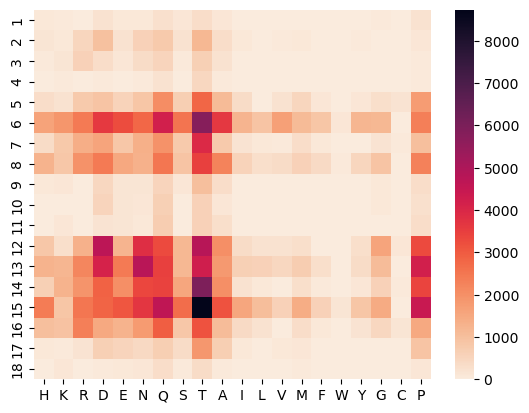

In [ ]:
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_ALL_mut_most_active.png', dpi=1200)

### AA frequency change in least active peptides

In [ ]:
least_act["difference_in_seq"] = [diff_func(x) for x in least_act["Sequence"]]

diff = least_act["difference_in_seq"].str.split("", n= -1, expand = True)

least_act =least_act.merge(diff, left_index=True, right_index=True)

least_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
14,PG1_3mut_14,RGGRLCYCWRCFCVCVGC,0.0,4.53,50.50,--------W-C------C,,-,-,-,-,-,-,-,-,W,-,C,-,-,-,-,-,-,C,
84,2mut_84,RGGRLCYCRRYFCVCVGF,0.0,3.61,45.89,----------Y------F,,-,-,-,-,-,-,-,-,-,-,Y,-,-,-,-,-,-,F,
139,PG1_3mut_139,RGLRLCYCGRRFCVCVGL,0.0,3.78,32.12,--L-----G--------L,,-,-,L,-,-,-,-,-,G,-,-,-,-,-,-,-,-,L,
409,PG1_3mut_409,RGGRLCYCRVRFWVCVIR,0.0,3.59,30.07,---------V--W---I-,,-,-,-,-,-,-,-,-,-,V,-,-,W,-,-,-,I,-,
444,PG1_3mut_444,SGGRLCYCRFRFCVCWGR,0.0,3.57,41.71,S--------F-----W--,,S,-,-,-,-,-,-,-,-,F,-,-,-,-,-,W,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652138,PG1_3mut_5652138,RGGIWCYCRRLFCVCVGR,0.0,3.65,56.76,---IW-----L-------,,-,-,-,I,W,-,-,-,-,-,L,-,-,-,-,-,-,-,
5652202,PG1_3mut_5652202,RGGRLCMCRRMFCVCVGW,0.0,3.75,33.03,------M---M------W,,-,-,-,-,-,-,M,-,-,-,M,-,-,-,-,-,-,W,
5652206,PG1_3mut_5652206,RGGNLCYCRRWFCWCVGR,0.0,3.54,53.12,---N------W--W----,,-,-,-,N,-,-,-,-,-,-,W,-,-,W,-,-,-,-,
5652367,PG1_3mut_5652367,RGGVLCYCFRWFCVCVGR,0.0,3.92,45.94,---V----F-W-------,,-,-,-,V,-,-,-,-,F,-,W,-,-,-,-,-,-,-,


In [ ]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = least_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,204,26,41,285,157,18,35,15,180,196,180,1,10,0,0,17,56,289
K,458,79,122,351,176,31,10,69,199,304,94,10,9,0,0,11,101,183
R,0,24,61,0,100,44,18,27,0,0,0,4,2,0,0,3,178,0
D,197,6,16,227,63,5,13,4,123,29,61,1,2,0,0,7,1,92
E,266,41,48,623,118,21,45,3,284,54,82,0,5,0,2,15,15,87
N,145,6,29,165,21,28,14,77,104,35,79,0,1,0,0,1,23,118
Q,61,2,7,77,5,1,2,2,35,14,20,0,2,0,0,0,12,67
S,320,59,108,520,178,52,124,198,810,593,763,28,37,9,0,32,70,438
T,114,6,12,84,35,1,10,25,143,71,75,1,2,0,0,0,5,91
A,131,29,29,205,94,1,79,8,446,136,116,1,2,1,0,17,33,256


<Axes: >

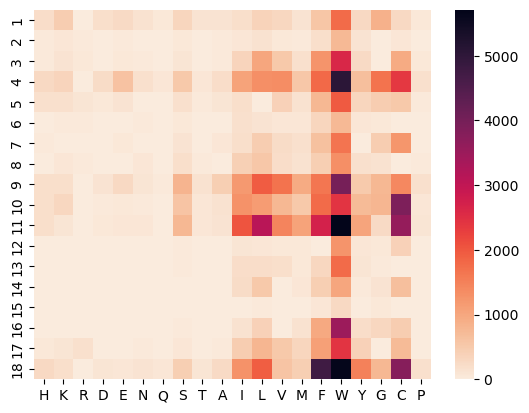

In [ ]:
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_ALL_mut_least_active_3.png' , dpi=1200)

In [ ]:
stop

NameError: name 'stop' is not defined

# Validation

In [ ]:
data_val = pd.read_excel('data/pg1_muts_validation_set.xlsx')
data_val.rename(columns={'Unnamed: 0': 'ID2'}, inplace=True)
data_val

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926


In [ ]:
#preds = predictions[predictions.Sequence.isin(data.Sequence)]
cols = ['ID', 'MBC_8_prob', 'selectivity_pred', 'hemolysis_pred']
data = data_val.merge(data[cols], how='inner', left_on='ID', right_on='ID')
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.00,-0.99,0.05
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.00,-1.22,-0.69
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.00,-1.31,-0.48
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.00,-0.69,-2.75
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.00,-0.25,0.45
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.00,-0.70,-1.78
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.00,-0.42,1.34
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.00,-0.84,-3.68
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.00,-0.70,-1.41
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.00,-0.34,-4.14


In [ ]:
most_act.Sequence.isin(data_val.Sequence).sum()

25

In [ ]:
#data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01.csv')

In [ ]:
stop

NameError: name 'stop' is not defined

## Hemolysis

In [ ]:
# Model evaluation on test data
hemo_true = data['%hemo']
hemo_pred = data['hemolysis_pred']

r2 = metrics.r2_score(hemo_true, hemo_pred)
mae = metrics.mean_absolute_error(hemo_true, hemo_pred)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(hemo_true, hemo_pred)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: 0.3405773769570475, MAE: 1.9159974009096814
Spearman correlation coefficient: 0.48
P-value: 0.00


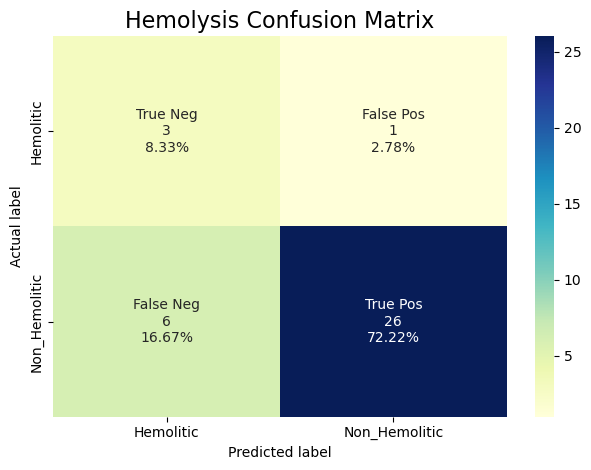

In [ ]:
#confusion_matrix, 
true = [1 if x <=2 else 0 for x in hemo_true]
pred = [1 if x<=2 else 0 for x in hemo_pred]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Hemolitic', 'Non_Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolysis Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.81
Recall: 0.81
Precision: 0.96
F1 Score: 0.88


In [ ]:
df = pd.DataFrame()
df_dict={'Version': 'V01', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.805556,0.8125,0.962963,0.881356


## Selectivity

In [ ]:
data2 = data[~data.L10Select.isna()]

# Model evaluation on test data
sel_true = data2['L10Select']
sel_pred = data2['selectivity_pred']

r2 = metrics.r2_score(sel_true, sel_pred)
mae = metrics.mean_absolute_error(sel_true, sel_pred)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(sel_true, sel_pred)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -4.5395114018040434, MAE: 1.1021618101513009
Spearman correlation coefficient: 0.41
P-value: 0.03


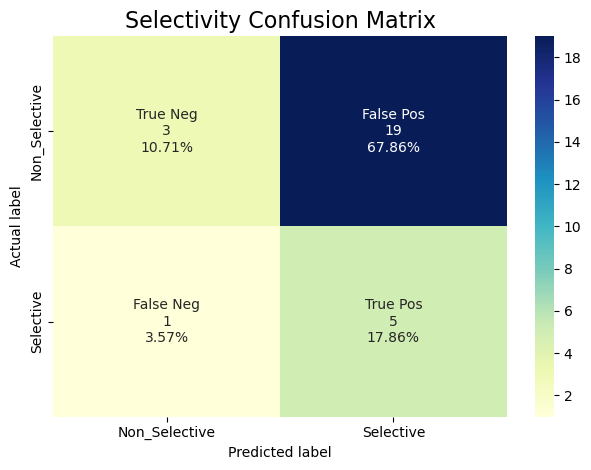

In [ ]:
#confusion_matrix, 
true = [1 if x<0.5 else 0 for x in sel_true]
pred = [1 if x<0.5 else 0 for x in sel_pred]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Selective', 'Selective']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Selectivity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.29
Recall: 0.83
Precision: 0.21
F1 Score: 0.33


In [ ]:
df_dict={'Version': 'V01', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.805556,0.812500,0.962963,0.881356
0,V01,Selectivity,0.285714,0.833333,0.208333,0.333333


## Activity

In [ ]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1

In [ ]:
# Load meta data
data['MIC'] = [convert_mic(x) for x in data['MIC MH']]
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.00,-0.99,0.05,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.00,-1.22,-0.69,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.00,-1.31,-0.48,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.00,-0.69,-2.75,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.00,-0.25,0.45,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.00,-0.70,-1.78,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.00,-0.42,1.34,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.00,-0.84,-3.68,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.00,-0.70,-1.41,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.00,-0.34,-4.14,0


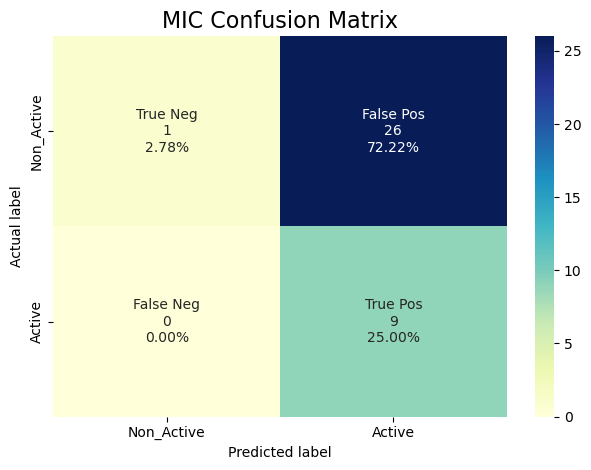

In [ ]:
#confusion_matrix, 
mic_true = data['MIC']
mic_pred = [1 if x==100 else 0 for x in data['MBC_8_prob'] ]

conf_m = metrics.confusion_matrix(mic_true, mic_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('MIC Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
accuracy = metrics.accuracy_score(mic_true, mic_pred)
recall = metrics.recall_score(mic_true, mic_pred)
precision = metrics.precision_score(mic_true, mic_pred)
f1_score = metrics.f1_score(mic_true, mic_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.28
Recall: 1.00
Precision: 0.26
F1 Score: 0.41


In [ ]:
df_dict={'Version': 'V01', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.805556,0.812500,0.962963,0.881356
0,V01,Selectivity,0.285714,0.833333,0.208333,0.333333
0,V01,Activity,0.277778,1.000000,0.257143,0.409091


In [ ]:
#df.to_csv('results/model_v01.1_performance.csv', index=False)

In [ ]:
df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.277778
1,V01,Activity,F1 Score,0.409091
2,V01,Activity,Precision,0.257143
3,V01,Activity,Recall,1.000000
4,V01,Hemolysis,Accuracy,0.805556
5,V01,Hemolysis,F1 Score,0.881356
6,V01,Hemolysis,Precision,0.962963
7,V01,Hemolysis,Recall,0.812500
8,V01,Selectivity,Accuracy,0.285714
9,V01,Selectivity,F1 Score,0.333333


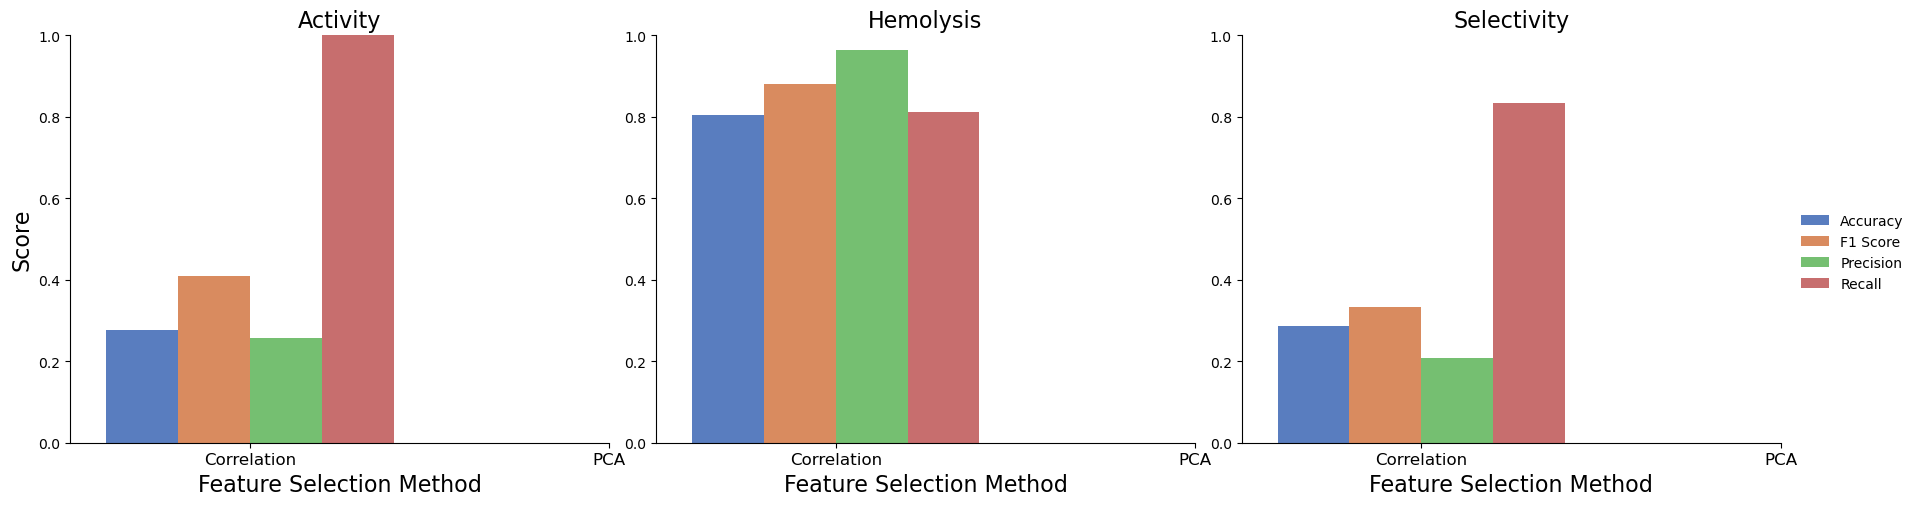

In [ ]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Version", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Feature Selection Method", "Score", size=16)


axes = g.axes.flatten()
axes[0].set_title("Activity", size=16)
axes[1].set_title("Hemolysis", size=16)
axes[2].set_title("Selectivity", size=16)

tick_labels = ['Correlation', 'PCA']
for ax in axes: 
    ax.set_xticks(range(len(tick_labels)))  # Set x-tick positions
    ax.set_xticklabels(tick_labels, size=12) 


g.add_legend()
#plt.savefig('results/model_v01-3_performance.png', dpi=1200)

IndexError: index 1 is out of bounds for axis 0 with size 1

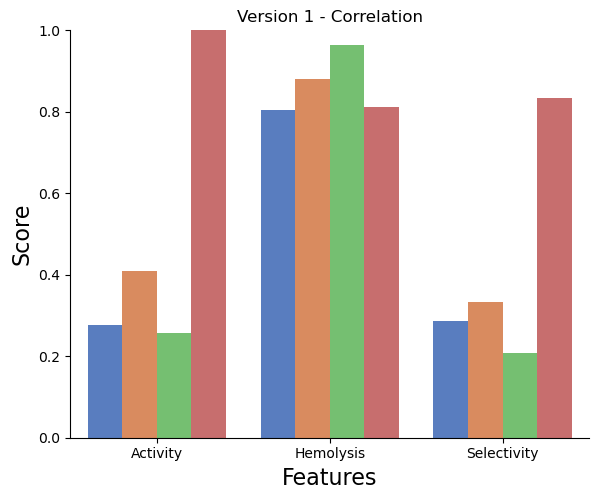

In [ ]:
g = sns.FacetGrid(df_melted, col="Version", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Feature", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Features", "Score", size=16)
#g.set_titles(col_template="{col_name}", row_template="{row_name}")
axes = g.axes.flatten()
axes[0].set_title("Version 1 - Correlation")
axes[1].set_title("Version 2 - PCA")

g.add_legend()
plt.show()